/home/ms6985/ParFlow-project/pfclm_sc
/home/ms6985/ParFlow-project/pfclm_sc/output_wb
/home/ms6985/ParFlow-project/pfclm_sc/output_wb/PFCLM_SC.out.0*.nc
/home/ms6985/ParFlow-project/pfclm_sc/output_wb/PFCLM_SC.out.CLM.*.nc
<xarray.Dataset> Size: 2MB
Dimensions:         (time: 8544, y: 1, x: 1, z: 19)
Coordinates:
  * time            (time) float64 68kB 1.0 2.0 3.0 ... 8.759e+03 8.76e+03
Dimensions without coordinates: y, x, z
Data variables: (12/13)
    eflx_lh_tot     (time, y, x) float64 68kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    eflx_lwrad_out  (time, y, x) float64 68kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    eflx_sh_tot     (time, y, x) float64 68kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    eflx_soil_grnd  (time, y, x) float64 68kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    qflx_evap_tot   (time, y, x) float64 68kB dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    qflx_evap_grnd  (time, y, x) float64 68kB dask.array<chunksize=(1, 

/tmp/ipykernel_1698526/3492488066.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


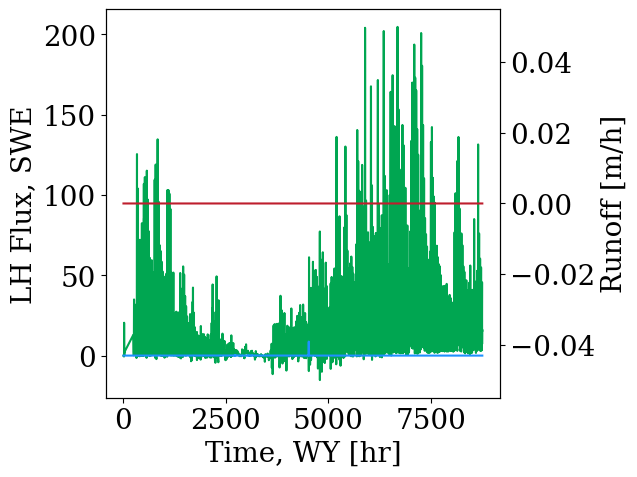

--- 18.70834183692932 seconds ---


In [36]:
## load PFCLM output and make plots / do anaylsis
## NetCDF version using XArray

from parflow.tools.fs import get_absolute_path
import matplotlib.pyplot as plt
import os
import numpy as np
#import netCDF4 as nc
import xarray as xr
import time
from set_demo_defaults import *
start_time = time.time()
print(os.getcwd())
relative_path_to_runfolder = 'output_wb'
base = get_absolute_path(relative_path_to_runfolder)
print(base)

alpha_vG = 100 #Set alpha for van Genuchten model

# reading the CLM file PFCLM_SC.out.clm_output.<file number>.C.pfb
# variables are by layer:
# 0  total latent heat flux (Wm-2)
# 1  total upward LW radiation (Wm-2)
# 2  total sensible heat flux (Wm-2)
# 3  ground heat flux (Wm-2)
# 4  net veg. evaporation and transpiration and soil evaporation (mms-1)
# 5  ground evaporation (mms-1)
# 6  soil evaporation (mms-1)
# 7  vegetation evaporation (canopy) and transpiration (mms-1)
# 8  transpiration (mms-1)
# 9  infiltration flux (mms-1)
# 10 SWE (mm)
# 11 ground temperature (K)
# 12 irrigation flux
# 13 - 24 Soil temperature by layer (K)

slope    = 0.05
mannings = 2.e-6

file_in = base+"/PFCLM_SC.out.0*.nc"
print(file_in)
pf_out = xr.open_mfdataset(file_in)

file_in = base+"/PFCLM_SC.out.CLM.*.nc"
print(file_in)
clm_out = xr.open_mfdataset(file_in)
print(clm_out)

# Plot LH Flux, SWE and Runoff
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(clm_out['time'][:],clm_out['eflx_lh_tot'][:,0,0], color=green)
ax.plot(clm_out['time'][:],clm_out['swe_out'][:,0,0], color=blue)
ax2.plot(pf_out['time'][:],(np.sqrt(slope)/mannings)*np.maximum(pf_out['pressure'][:,19,0,0],0.0)**(5.0/3.0), color=red)
ax.set_xlabel('Time, WY [hr]')
ax.set_ylabel('LH Flux, SWE')
ax2.set_ylabel('Runoff [m/h]')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.legend(loc='best', frameon=False)
plt.savefig(f'PFCLM_plot_alpha{alpha_vG}_shorttime.pdf',bbox_inches='tight', dpi = 600)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

/home/ms6985/ParFlow-project/pfclm_sc
/home/ms6985/ParFlow-project/pfclm_sc/output


/tmp/ipykernel_1698526/2053402772.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


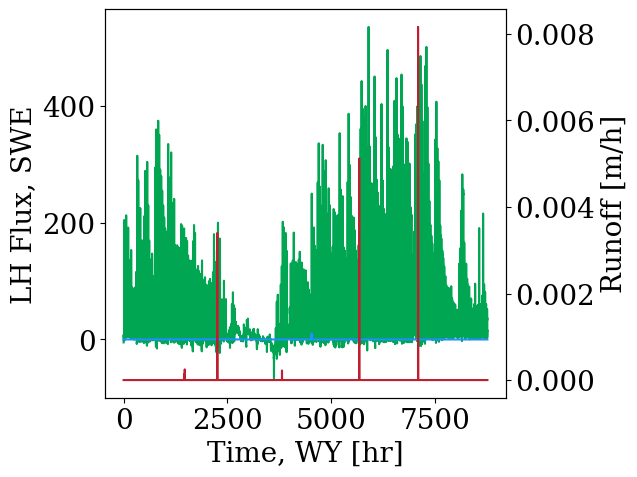

--- 3.9888057708740234 seconds ---


In [37]:
## load PFCLM output and make plots / do analysis
## PFB reader, in a loop

import parflow as pf
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import time as timer
from parflow.tools.fs import get_absolute_path

start_time = timer.time()

print(os.getcwd())
relative_path_to_runfolder = 'output'
path = get_absolute_path(relative_path_to_runfolder)
print(path)

# intialize data and time arrays
data    = np.zeros([8,8760])
time    = np.zeros([8760])

# reading the CLM file PFCLM_SC.out.clm_output.<file number>.C.pfb
# variables are by layer:
# 0  total latent heat flux (Wm-2)
# 1  total upward LW radiation (Wm-2)
# 2  total sensible heat flux (Wm-2)
# 3  ground heat flux (Wm-2)
# 4  net veg. evaporation and transpiration and soil evaporation (mms-1)
# 5  ground evaporation (mms-1)
# 6  soil evaporation (mms-1)
# 7  vegetation evaporation (canopy) and transpiration (mms-1)
# 8  transpiration (mms-1)
# 9  infiltration flux (mms-1)
# 10 SWE (mm)
# 11 ground temperature (K)
# 12 irrigation flux
# 13 - 24 Soil temperature by layer (K)

slope    = 0.05
mannings = 2.e-6

# loop over a year of files (8760 hours) and load in the CLM output
# then map specific variables to the data array which holds things for analysis
# and plotting
for icount in range(1, 8760):
    base = path+"/PFCLM_SC.out.clm_output.{:05d}.C.pfb"
    filename = base.format(icount)
    CLM_data = pf.read_pfb(filename)

    data[1,icount] = CLM_data[0,0,0]  #total latent heat flux (Wm-2)
    data[2,icount] = CLM_data[4,0,0]  #net veg. evaporation and transpiration and soil evaporation (mms-1)
    data[3,icount] = CLM_data[10,0,0] #SWE (mm)
    base = path+"/PFCLM_SC.out.press.{:05d}.pfb"
    filename = base.format(icount)
    data_arr = pf.read_pfb(filename)    
    data[4,icount] = (np.sqrt(slope)/mannings) * np.maximum(data_arr[19,0,0],0.0)**(5.0/3.0)
    time[icount] = icount

# Plot LH Flux, SWE and Runoff
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(time[1:8760],data[1,1:8760], color=green)
ax.plot(time[1:8760],data[3,1:8760], color=blue)
ax2.plot(time[1:8760],data[4,1:8760], color=red)
ax.set_xlabel('Time, WY [hr]')
ax.set_ylabel('LH Flux, SWE')
ax2.set_ylabel('Runoff [m/h]')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.legend(loc='best', frameon=False)
plt.savefig(f'PFCLM_plot_alpha{alpha_vG}_longtime1.pdf',bbox_inches='tight', dpi = 600)
plt.show()

print("--- %s seconds ---" % (timer.time() - start_time))

/home/ms6985/ParFlow-project/pfclm_sc
/home/ms6985/ParFlow-project/pfclm_sc/output


/tmp/ipykernel_1698526/2795197059.py:65: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


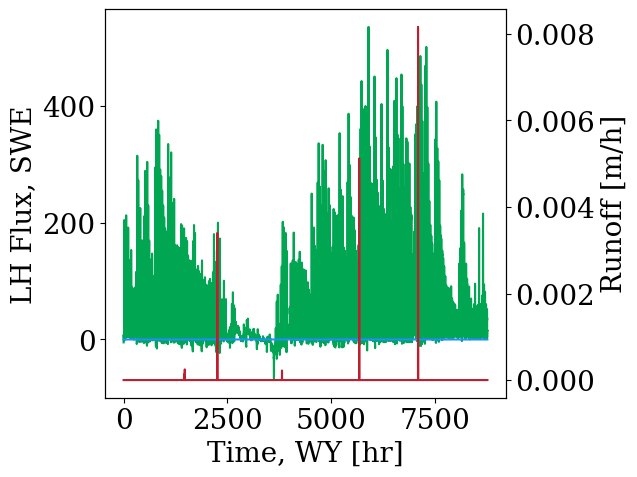

--- 1.5412163734436035 seconds ---


In [38]:
## load PFCLM output and make plots / do anaylsis
## PFB read as a sequence

import parflow as pf
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import time as timer
from parflow.tools.fs import get_absolute_path
from glob import glob

start_time = timer.time()

print(os.getcwd())
relative_path_to_runfolder = 'output'
path = get_absolute_path(relative_path_to_runfolder)
print(path)

# intialize data and time arrays
data    = np.zeros([8,8760])
time    = np.zeros([8760])

# reading the CLM file PFCLM_SC.out.clm_output.<file number>.C.pfb
# variables are by layer:
# 0  total latent heat flux (Wm-2)
# 1  total upward LW radiation (Wm-2)
# 2  total sensible heat flux (Wm-2)
# 3  ground heat flux (Wm-2)
# 4  net veg. evaporation and transpiration and soil evaporation (mms-1)
# 5  ground evaporation (mms-1)
# 6  soil evaporation (mms-1)
# 7  vegetation evaporation (canopy) and transpiration (mms-1)
# 8  transpiration (mms-1)
# 9  infiltration flux (mms-1)
# 10 SWE (mm)
# 11 ground temperature (K)
# 12 irrigation flux
# 13 - 24 Soil temperature by layer (K)

slope    = 0.05
mannings = 2.e-6
# loop over a year and assemble files to be loaded as an entire sequence
# then map specific variables to the data array which holds things for analysis
# and plotting

files = glob(path+"/PFCLM_SC.out.clm_output.*.C.pfb")
CLM_data = pf.read_pfb_sequence(files)

files = glob(path+"/PFCLM_SC.out.press.*.pfb")
pf_data = pf.read_pfb_sequence(files)    
# calculate runoff
runoff = (np.sqrt(slope)/mannings) * np.maximum(pf_data[:,19,0,0],0.0)**(5.0/3.0)

# Plot LH Flux, SWE and Runoff
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(CLM_data[:,0,0,0], color=green)
ax.plot(CLM_data[:,4,0,0], color=blue)
ax2.plot(runoff[:], color=red)
ax.set_xlabel('Time, WY [hr]')
ax.set_ylabel('LH Flux, SWE')
ax2.set_ylabel('Runoff [m/h]')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.legend(loc='best', frameon=False)
plt.savefig(f'PFCLM_plot_alpha{alpha_vG}_longtime2.pdf',bbox_inches='tight', dpi = 600)
plt.show()

print("--- %s seconds ---" % (timer.time() - start_time))